# Import Data

In [1]:
import pandas as pd
train_df = pd.read_csv('../../input/feedback-prize-english-language-learning/train.csv')


model_path_list = [
    '../../01_Baseline/exp/result/01_v1_24/oof_df.csv', # deberta-base
    '../../01_Baseline/exp/result/01_v1_25/oof_df.csv', # deberta-large
    '../../01_Baseline/exp/result/01_v1_27/oof_df.csv', # deberta-v3-base

    '../../01_Baseline/exp/result/01_v1_43/oof_df.csv', # deberta-v3-large
    '../../01_Baseline/exp/result/01_v1_44/oof_df.csv', # roberta-base
    '../../01_Baseline/exp/result/01_v1_45/oof_df.csv', # roberta-large
    '../../01_Baseline/exp/result/01_v1_47/oof_df.csv', # electra-base
    '../../01_Baseline/exp/result/01_v1_49/oof_df.csv', # deepset/roberta-base-squad2
    '../../01_Baseline/exp/result/01_v1_50/oof_df.csv', # distilroberta-base
    
    '../../01_Baseline/exp/result/01_v1_54/oof_df.csv', # electra-large
    '../../01_Baseline/exp/result/01_v1_55/oof_df.csv', # deepset/roberta-large-squad2
    '../../01_Baseline/exp/result/01_v1_56/oof_df.csv', # xlm-roberta-large
    '../../01_Baseline/exp/result/01_v1_59/oof_df.csv', # bert-large-cased-whole-word-masking
    '../../01_Baseline/exp/result/01_v1_60/oof_df.csv', # bert-large-cased
    '../../07_Embeddings/exp/result/07_v1_01/oof_df_svr_notebook_v03.csv', # svr
    
]

oof_df_list = [
    pd.read_csv(model_path) for model_path in model_path_list
]

for oof_df in oof_df_list:
    oof_df = train_df[['text_id']].merge(oof_df, how='left', on='text_id')
    
num_models = len(model_path_list)

TARGET_COLS = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']

stack_df = oof_df_list[0][['text_id']]
for i in range(num_models):
    oof_df = oof_df_list[i]
    for col in TARGET_COLS:
        stack_df[f'{col}_{i}'] = oof_df[col].values
        
        
train_df = train_df[['text_id']+TARGET_COLS].merge(stack_df, on='text_id', how='left')

/home/takesako/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
train_df.head()

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_0,syntax_0,vocabulary_0,...,vocabulary_13,phraseology_13,grammar_13,conventions_13,cohesion_14,syntax_14,vocabulary_14,phraseology_14,grammar_14,conventions_14
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0,3.019583,3.031228,3.068353,...,3.136100,3.054777,3.188607,2.866543,3.090008,2.942046,3.104937,3.210109,3.330849,2.864747
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5,2.660616,2.499767,2.859407,...,2.964505,2.882491,2.566260,2.645195,2.544430,2.470382,2.831750,2.606420,2.401873,2.524009
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5,2.796222,2.757307,2.909814,...,3.095113,3.084174,3.067044,3.060621,2.797657,2.960948,3.124284,2.961082,2.972845,3.013185
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0,3.767042,3.684418,3.786009,...,3.787250,3.746300,3.615203,3.738615,3.569966,3.596947,3.599233,3.713636,3.782764,3.773484
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5,2.513415,2.274921,2.641665,...,2.567789,2.513104,2.422624,2.236006,2.622300,2.448069,2.731655,2.892202,2.687519,2.394289


# Features

In [3]:
feature_cols = [col for col in stack_df.columns if col!='text_id']

# Data Split

In [4]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v1_02/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [5]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':feature_cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [6]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiRMSE',
}

import numpy as np
def calc_metric(pred, gt):
    '''
    pred : (num_data, num_labels)
    gt : (num_data, num_labels)
    '''
    score = np.sqrt(np.mean((pred - gt)**2, axis=0))
    score = score.mean()
    return score

fold0 : CV=0.4542


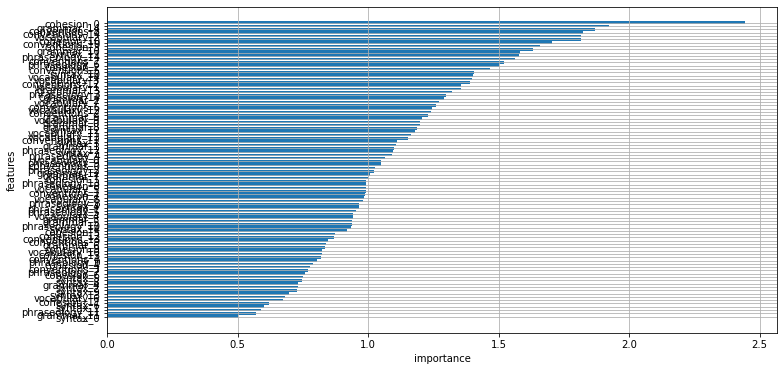

fold1 : CV=0.4468


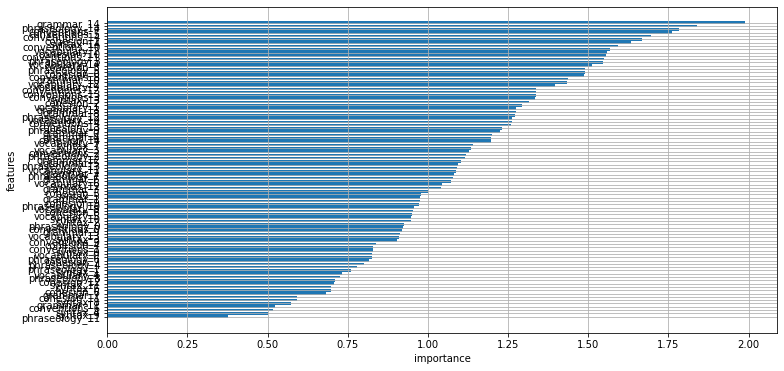

fold2 : CV=0.4471


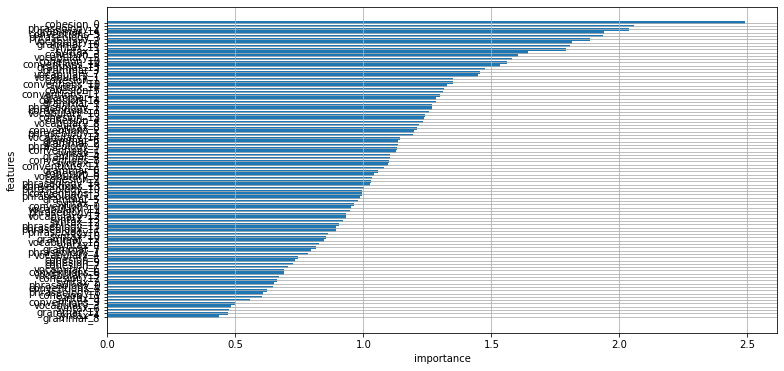

fold3 : CV=0.4579


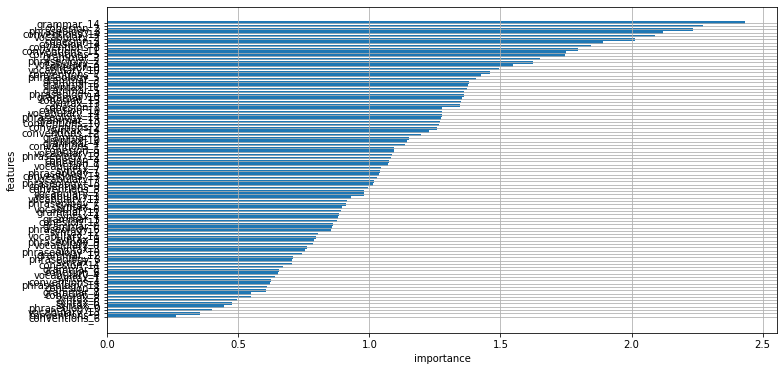

fold4 : CV=0.4570


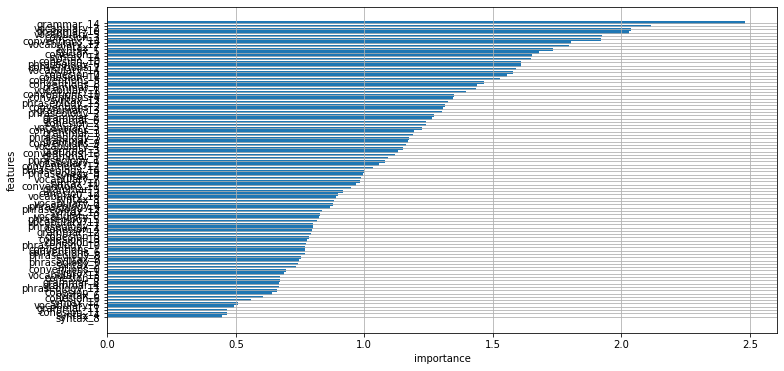

CV=0.4526


In [7]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cat_features = []


score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['text_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['text_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    pool_trn = catboost.Pool(trn_df[feature_cols].values, label=trn_df[TARGET_COLS].values, cat_features=cat_features)
    pool_val = catboost.Pool(val_df[feature_cols].values, label=val_df[TARGET_COLS].values, cat_features=cat_features)

    model = catboost.CatBoostRegressor(**params)
    model.fit(pool_trn, 
              eval_set=[pool_val], 
              verbose=0, 
              early_stopping_rounds=100,
             )

    pred = model.predict(pool_val)
    target = val_df[TARGET_COLS].values
    score = calc_metric(pred, target)
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    for i,col in enumerate(TARGET_COLS):
        val_df[f'oof_{col}'] = pred[:,i]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [8]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['text_id']].merge(oof_df, on='text_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(3911, 103)


,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions,cohesion_0,syntax_0,vocabulary_0,...,vocabulary_14,phraseology_14,grammar_14,conventions_14,oof_cohesion,oof_syntax,oof_vocabulary,oof_phraseology,oof_grammar,oof_conventions
0,0016926B079C,3.5,3.5,3.0,3.0,4.0,3.0,3.019583,3.031228,3.068353,...,3.104937,3.210109,3.330849,2.864747,2.971695,2.924514,3.128621,3.103902,3.173768,2.882423
1,0022683E9EA5,2.5,2.5,3.0,2.0,2.0,2.5,2.660616,2.499767,2.859407,...,2.831750,2.606420,2.401873,2.524009,2.629216,2.548302,2.866617,2.646336,2.538000,2.505187
2,00299B378633,3.0,3.5,3.0,3.0,3.0,2.5,2.796222,2.757307,2.909814,...,3.124284,2.961082,2.972845,3.013185,2.884262,2.892042,3.060724,2.930287,2.971204,3.018568
3,003885A45F42,4.5,4.5,4.5,4.5,4.0,5.0,3.767042,3.684418,3.786009,...,3.599233,3.713636,3.782764,3.773484,3.633677,3.565500,3.680856,3.692850,3.641996,3.700554
4,0049B1DF5CCC,2.5,3.0,3.0,3.0,2.5,2.5,2.513415,2.274921,2.641665,...,2.731655,2.892202,2.687519,2.394289,2.537614,2.409738,2.758368,2.574863,2.468971,2.387048


In [9]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = calc_metric(oof_df[cols].values, oof_df[TARGET_COLS].values)
print('oof={:.4f}'.format(oof_score))

oof=0.4527
